# Notebook 3: Model Development & Training

**Objective:** Design and train a deep learning model that predicts both drum onsets and velocities from mel spectrograms.

This notebook implements our drum transcription neural network architecture, loss functions, and training pipeline. The model has dual heads for both onset detection and velocity prediction, allowing it to capture not just when a drum is hit but also how hard it's played.

## 1. Imports and Setup

Loading required libraries for model development, training, and evaluation.

In [1]:
# This so the GPU doesnt crash
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import random
import os
import time
import sys
from sklearn.metrics import precision_recall_fscore_support


# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
DATA_DIR = Path("../data")
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODEL_SAVE_DIR = Path("../models")
MODEL_SAVE_DIR.mkdir(exist_ok=True, parents=True)

# Drum mapping (same as in previous notebooks)
GM_DRUM_MAPPING = {
        36: "Kick",
        38: "Snare",
        42: "HiHat",
        47: "Tom",
        49: "Crash",
        51: "Ride"
    }

# Drum types constants
MAIN_DRUMS = list(GM_DRUM_MAPPING.keys())
MAIN_DRUM_NAMES = list(GM_DRUM_MAPPING.values())
N_DRUMS = len(MAIN_DRUMS)

# Configure plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_theme(style="whitegrid")

def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, f1_scores,
                    best_val_f1, patience_counter, filename):
    """Save a complete checkpoint that can be used to resume training."""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'f1_scores': f1_scores,
        'best_val_f1': best_val_f1,
        'patience_counter': patience_counter,
        # Store model config for easy reloading later (optional but recommended)
        'model_config': {
            'n_mels': model.n_mels,
            'n_drums': model.n_drums,
            'use_lstm': model.use_lstm,
            'lstm_hidden_size': model.lstm.hidden_size if model.use_lstm else None,
            'dropout': model.dropout_rate # Assuming you stored dropout rate in model
        }
    }, filename)
    print(f"Checkpoint saved to {filename}")

def load_checkpoint(filename, model, optimizer, scheduler=None):
    """Load a checkpoint to resume training."""
    filepath = Path(filename)
    if not filepath.exists():
        print(f"Checkpoint {filename} not found. Starting from scratch.")
        # Return defaults, ensuring best_val_f1 starts low for maximization
        return 0, [], [], [], -1.0, 0

    print(f"Loading checkpoint from {filename}")
    checkpoint = torch.load(filepath, map_location=device)

    # Load model state - check compatibility if needed
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
         try:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
         except Exception as e:
             print(f"Warning: Could not load scheduler state dict: {e}. Scheduler may restart.")


    start_epoch = checkpoint.get('epoch', -1) + 1 # Resume from next epoch
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    f1_scores = checkpoint.get('f1_scores', [])
    # Load best_val_f1, default to -1.0 if not found (for maximization)
    best_val_f1 = checkpoint.get('best_val_f1', -1.0)
    patience_counter = checkpoint.get('patience_counter', 0)

    print(f"Resuming from epoch {start_epoch}. Best Valid F1 so far: {best_val_f1:.4f}")

    return start_epoch, train_losses, val_losses, f1_scores, best_val_f1, patience_counter

Using device: cuda


## 2. Create Dataset and DataLoader

Loading our preprocessed training examples (.npz files) and setting up the PyTorch data pipeline.

In [3]:
def create_small_dataset(data_dir, split, max_files=20):
    """Create a small toy dataset for testing the pipeline."""
    full_dir = Path(data_dir) / split
    all_files = list(full_dir.glob("*.npz"))

    print(f"Found {len(all_files)} total files for {split}")
    if len(all_files) <= max_files:
        return all_files

    # Take a random sample of files
    sampled_files = random.sample(all_files, max_files)
    print(f"Sampled {len(sampled_files)} files for {split} toy dataset")
    return sampled_files

class DrumTranscriptionDataset(Dataset):
    """Dataset for loading preprocessed drum transcription examples."""

    def __init__(self, data_dir, split="train", toy_mode=False, max_files=20):
        """
        Initialize the dataset.

        Args:
            data_dir: Directory containing the processed data
            split: Which dataset split to use ('train', 'validation', or 'test')
            toy_mode: If True, use only a small subset of files
            max_files: Maximum number of files to use in toy mode
        """
        self.data_dir = Path(data_dir) / split

        #
        self.use_checkpoint = True

        if toy_mode:
            self.file_list = create_small_dataset(data_dir, split, max_files)
        else:
            self.file_list = list(self.data_dir.glob("*.npz"))

        if len(self.file_list) == 0:
            raise ValueError(f"No .npz files found in {self.data_dir}")

        print(f"Using {len(self.file_list)} examples in {split} set")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Load the NPZ file
        data = np.load(self.file_list[idx])

        # Extract features and targets
        mel_spec = data["mel_spec"].astype(np.float32)  # [n_mels, n_frames]
        onset_target = data["onset_target"].astype(np.float32)  # [n_drums, n_frames]
        velocity_target = data["velocity_target"].astype(np.float32)  # [n_drums, n_frames]

        # Add normalization to ensure inputs are scaled properly
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)

        # Convert to tensors
        mel_spec = torch.from_numpy(mel_spec)
        onset_target = torch.from_numpy(onset_target)
        velocity_target = torch.from_numpy(velocity_target)

        return {
            "input": mel_spec,
            "onset_target": onset_target,
            "velocity_target": velocity_target,
            "file_path": str(self.file_list[idx])
        }

def collate_fn(batch):
    """
    Custom collate function to handle variable-length sequences.
    Pads sequences to the maximum length in the batch.
    """
    # Get max sequence length in this batch
    max_frames = max(item["input"].shape[1] for item in batch)

    # Initialize tensors for batched data
    batch_size = len(batch)
    n_mels = batch[0]["input"].shape[0]
    n_drums = batch[0]["onset_target"].shape[0]

    # Create padded tensors
    inputs = torch.zeros((batch_size, n_mels, max_frames))
    onset_targets = torch.zeros((batch_size, n_drums, max_frames))
    velocity_targets = torch.zeros((batch_size, n_drums, max_frames))
    file_paths = []

    # Fill in the data
    for i, item in enumerate(batch):
        frames = item["input"].shape[1]
        inputs[i, :, :frames] = item["input"]
        onset_targets[i, :, :frames] = item["onset_target"]
        velocity_targets[i, :, :frames] = item["velocity_target"]
        file_paths.append(item["file_path"])

    return {
        "input": inputs,
        "onset_target": onset_targets,
        "velocity_target": velocity_targets,
        "file_paths": file_paths
    }


In [4]:
# Create datasets
train_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="train")
val_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="validation")
test_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="test")

# Create dataloaders
batch_size = 1
num_workers = 4
pin_memory = False
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

Using 3187 examples in train set
Using 683 examples in validation set
Using 684 examples in test set


### 2.1 Inspect a Batch

Let's examine a batch of data to understand the input and target formats.

Input shape: torch.Size([1, 229, 216])
Onset target shape: torch.Size([1, 6, 216])
Velocity target shape: torch.Size([1, 6, 216])


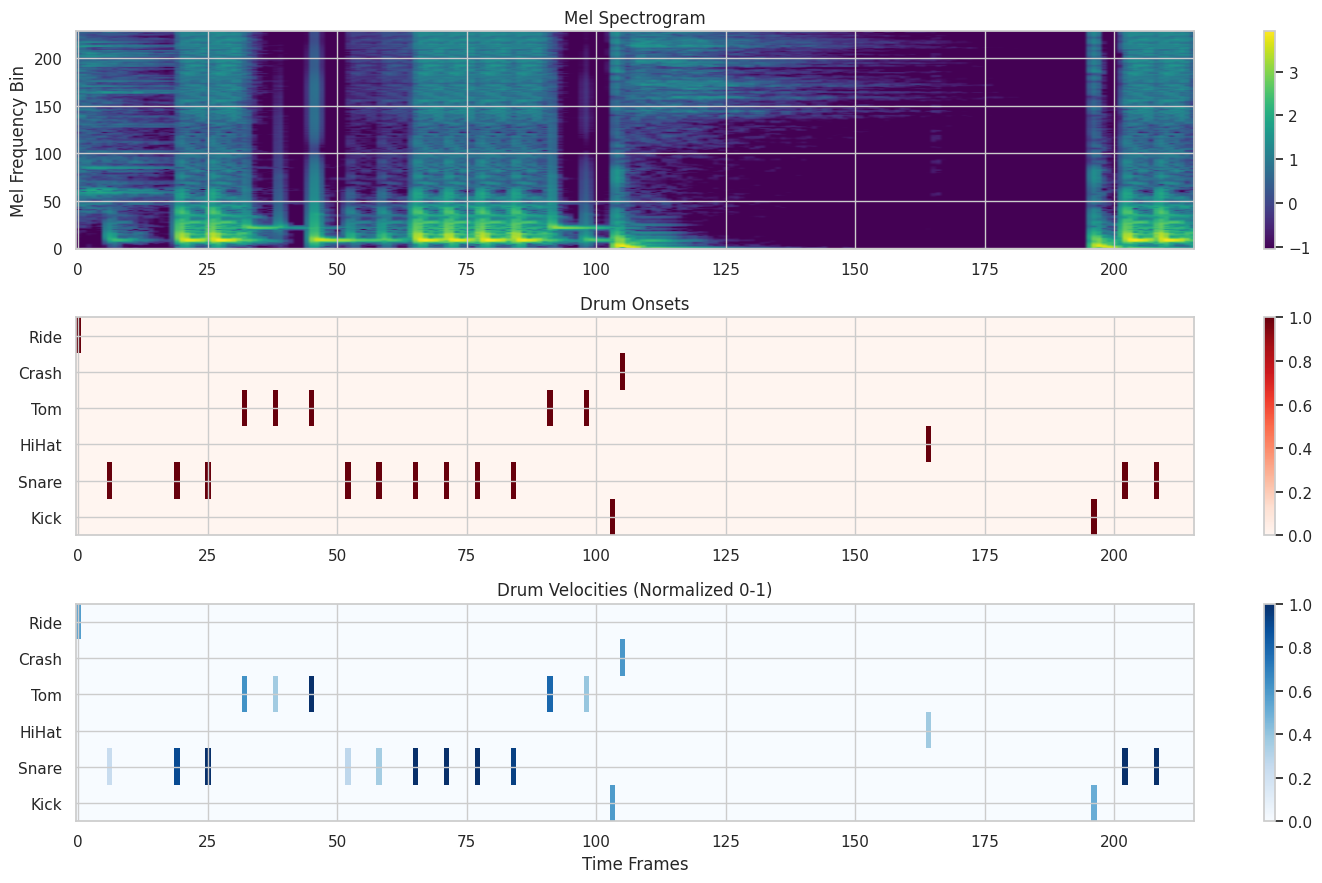

In [5]:
# Get a batch from the training loader
for batch in train_loader:
    inputs = batch["input"]
    onset_targets = batch["onset_target"]
    velocity_targets = batch["velocity_target"]

    print(f"Input shape: {inputs.shape}")  # [batch_size, n_mels, n_frames]
    print(f"Onset target shape: {onset_targets.shape}")  # [batch_size, n_drums, n_frames]
    print(f"Velocity target shape: {velocity_targets.shape}")  # [batch_size, n_drums, n_frames]

    # Plot one example
    idx = 0  # First example in batch
    plt.figure(figsize=(15, 9))

    # Plot mel spectrogram
    plt.subplot(3, 1, 1)
    plt.imshow(inputs[idx].numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title('Mel Spectrogram')
    plt.ylabel('Mel Frequency Bin')

    # Plot onset targets
    plt.subplot(3, 1, 2)
    plt.imshow(onset_targets[idx].numpy(), aspect='auto', origin='lower', cmap='Reds')
    plt.colorbar()
    plt.title('Drum Onsets')
    plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)

    # Plot velocity targets
    plt.subplot(3, 1, 3)
    plt.imshow(velocity_targets[idx].numpy(), aspect='auto', origin='lower', cmap='Blues')
    plt.colorbar()
    plt.title('Drum Velocities (Normalized 0-1)')
    plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)
    plt.xlabel('Time Frames')

    plt.tight_layout()
    plt.show()

    # Just examine one batch
    break

## 3. Define Model Architecture

Create our drum transcription model based on a CNN architecture with dual output heads.

In [6]:
class ConvBlock(nn.Module):
    """Convolutional block with batch normalization and ReLU activation."""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class DrumTranscriptionModel(nn.Module):
    """CNN model for drum transcription with dual output heads."""

    def __init__(self, n_mels=229, n_drums=6, use_lstm=True, lstm_hidden_size=256, dropout=0.3):
        """
        Initialize the model.

        Args:
            n_mels: Number of mel frequency bands in input
            n_drums: Number of drum types to detect
            use_lstm: Whether to use LSTM layers for temporal modeling
        """
        super(DrumTranscriptionModel, self).__init__()
        self.n_mels = n_mels
        self.n_drums = n_drums
        self.use_lstm = use_lstm
        self.dropout_rate = dropout

        # Feature extraction: convolutional layers
        self.conv_stack = nn.Sequential(
            # Layer 1: [B, 1, n_mels, T] -> [B, 32, n_mels//2, T]
            ConvBlock(1, 32),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Frequency pooling

            # Layer 2: [B, 32, n_mels//2, T] -> [B, 64, n_mels//4, T]
            ConvBlock(32, 64),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Frequency pooling

            # Layer 3: [B, 64, n_mels//4, T] -> [B, 128, n_mels//8, T]
            ConvBlock(64, 128),
            nn.MaxPool2d(kernel_size=(2, 1)),  # Frequency pooling

            # Layer 4: [B, 128, n_mels//8, T] -> [B, 128, n_mels//16, T]
            ConvBlock(128, 128),
            nn.MaxPool2d(kernel_size=(2, 1))   # Frequency pooling
        )

        # Calculate feature dimensions after CNN
        self.cnn_output_freq_dim = n_mels // 16
        self.cnn_output_channels = 128
        self.cnn_output_dim = self.cnn_output_channels * self.cnn_output_freq_dim

        # Optional: Bi-directional LSTM layer for temporal modeling
        if self.use_lstm:
            self.lstm = nn.LSTM(
                input_size=self.cnn_output_dim,
                hidden_size=lstm_hidden_size,
                num_layers=1,  # Could also make num_layers but idk
                batch_first=True,
                bidirectional=True,
                # Pass 0 dropout to LSTM if num_layers=1 to avoid warning
                dropout=0
            )
            # Apply dropout after LSTM if specified and num_layers is 1
            self.lstm_dropout = nn.Dropout(
                self.dropout_rate) if self.dropout_rate > 0 else nn.Identity()
            # bidirectional LSTM output (2 * hidden_size)
            feature_dim = lstm_hidden_size * 2
        else:
            feature_dim = self.cnn_output_dim
            self.lstm = None
            self.lstm_dropout = nn.Identity()

        # Onset detection head
        self.onset_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(128, n_drums),
            # Using logits
        )

        self.velocity_head = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(128, n_drums),
            nn.ReLU()
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape [batch_size, n_mels, n_frames]

        Returns:
            Tuple of (onset_predictions, velocity_predictions)
        """
        batch_size, n_mels, n_frames = x.shape
        x = x.unsqueeze(1)  # [B, 1, n_mels, T]

        # CNN forward
        x = self.conv_stack(x)  # [B, C, n_mels_reduced, T]

        # Reshape for RNN/Linear
        x = x.permute(0, 3, 1, 2)  # [B, T, C, n_mels_reduced]
        # Combine channel and frequency dims
        # [B, T, C * n_mels_reduced]
        x = x.reshape(batch_size, n_frames, self.cnn_output_dim)

        # Optional LSTM forward
        if self.use_lstm:
            x, _ = self.lstm(x)  # [B, T, 2 * hidden_size]
            x = self.lstm_dropout(x)  # Apply dropout

        # Output heads forward
        onset_logits = self.onset_head(x)  # [B, T, n_drums] - Logits
        # [B, T, n_drums] - Velocities >= 0
        velocity_pred = self.velocity_head(x)

        # Reshape to match target format [B, n_drums, T]
        onset_logits = onset_logits.transpose(1, 2)
        velocity_pred = velocity_pred.transpose(1, 2)

        # onset_logits are the raw outputs before sigmoid
        # velocity_pred are the predicted velocities (>= 0 due to final ReLU)
        return onset_logits, velocity_pred

## 4. Define Loss Functions

We'll define a combined loss function that handles both onset detection (binary cross entropy) and velocity prediction (mean squared error).

In [7]:
def combined_loss_function(
    onset_logits,
    velocity_pred,
    onset_target,
    velocity_target,
    onset_weight=0.8,
    positive_weight=10.0
):
    """
    Combined loss for both onset detection and velocity prediction.

    Args:
        onset_pred: Onset predictions [B, n_drums, T]
        velocity_pred: Velocity predictions [B, n_drums, T]
        onset_target: Onset targets [B, n_drums, T]
        velocity_target: Velocity targets [B, n_drums, T]
        onset_weight: Weight for onset loss (velocity_weight = 1 - onset_weight)

    Returns:
        Tuple of (combined_loss, onset_loss, velocity_loss)
    """
    onset_target = onset_target.float()
    # Create weight tensor with high values for positive examples
    weights = torch.ones_like(onset_target, device=onset_logits.device)
    weights[onset_target > 0.5] = positive_weight

    # Use binary_cross_entropy_with_logits instead of binary_cross_entropy
    onset_loss = F.binary_cross_entropy_with_logits(
        onset_logits,
        onset_target,
        weight=weights
    )

    mask = onset_target > 0.5
    if mask.sum() > 0:
        velocity_loss = F.mse_loss(velocity_pred[mask], velocity_target.float()[mask])
    else:
        velocity_loss = torch.tensor(0.0, device=onset_logits.device, dtype=torch.float32)

    velocity_weight = 1.0 - onset_weight
    combined = onset_weight * onset_loss + velocity_weight * velocity_loss

    return combined, onset_loss, velocity_loss

## 5. Training Loop

Define functions to train the model and evaluate it on validation data.

In [8]:
def train_epoch(model, train_loader, optimizer, device, onset_weight=0.8, positive_weight=10.0, scaler=None, accum_steps=4):
    """Train the model for one epoch with gradient accumulation and mixed precision."""
    model.train()
    epoch_loss = 0
    epoch_onset_loss = 0
    epoch_velocity_loss = 0
    processed_samples = 0

    optimizer.zero_grad()
    progress_bar = tqdm(train_loader, desc="Training")
    for i, batch in enumerate(progress_bar):
        # Move data to device
        inputs = batch["input"].to(device)
        onset_target = batch["onset_target"].to(device)
        velocity_target = batch["velocity_target"].to(device)
        batch_size = inputs.size(0)

        # Forward pass with mixed precision
        with torch.amp.autocast(device_type='cuda', enabled=scaler is not None):
            # Model output are logits and velocity predictions
            onset_logits, velocity_pred = model(inputs)

            # Loss calculation uses logits directly
            loss, onset_loss_val, velocity_loss_val = combined_loss_function(
                onset_logits, velocity_pred, onset_target, velocity_target,
                onset_weight=onset_weight,
                positive_weight=positive_weight
            )

            # Scale the loss by accumulation steps
            loss = loss / accum_steps

        if scaler:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        # Only update weights after accumulating gradients for accum_steps batches
        if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
            if scaler:
                # Unscale before optimizer step (helps with gradient clipping if used)
                scaler.unscale_(optimizer)
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Example clipping
                # Update weights with scaling aware step
                scaler.step(optimizer)

                # Update the scaler
                scaler.update()
            else:
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Example clipping
                optimizer.step()

            # Zero gradients for next batch
            optimizer.zero_grad()

        # Log unscaled loss values per sample
        epoch_loss += loss.item() * accum_steps * batch_size  # total loss for the batch
        epoch_onset_loss += onset_loss_val.item() * batch_size
        epoch_velocity_loss += velocity_loss_val.item() * batch_size
        processed_samples += batch_size

        progress_bar.set_postfix({
            'loss': f"{loss.item() * accum_steps:.4f}",  # Batch avg loss
            'ons_loss': f"{onset_loss_val.item():.4f}",
            'vel_loss': f"{velocity_loss_val.item():.4f}"
        })

    # Return average loss per sample for the epoch
    return {
        'loss': epoch_loss / processed_samples,
        'onset_loss': epoch_onset_loss / processed_samples,
        'velocity_loss': epoch_velocity_loss / processed_samples
    }


def validate(model, val_loader, device, onset_weight=0.8, positive_weight=10.0, fixed_threshold=None):
    """
    Evaluate the model on validation data.
    Optimizes the detection threshold based on **Macro F1 Score**.

    Args:
        model: The model to evaluate.
        val_loader: DataLoader for validation data.
        device: Device to run on (CPU or GPU).
        onset_weight: Weight for onset loss component.
        positive_weight: Weight for positive examples in BCE loss.
        fixed_threshold: If provided, use this threshold instead of optimizing.

    Returns:
        Dictionary of metrics including the optimized threshold.
    """
    model.eval()
    val_loss = 0
    val_onset_loss = 0
    val_velocity_loss = 0
    processed_samples = 0

    # Lists to store predictions and targets across all batches for metric calculation
    all_onset_probs_flat = []
    all_onset_targets_flat = []


    all_drum_probs = {i: [] for i in range(model.n_drums)}
    all_drum_targets = {i: [] for i in range(model.n_drums)}

    with torch.no_grad():
        # leave=False if inside another loop
        progress_bar = tqdm(val_loader, desc="Validating", leave=False)
        for batch in progress_bar:
            # Move data to the computation device
            inputs = batch["input"].to(device)
            onset_target = batch["onset_target"].to(device)
            velocity_target = batch["velocity_target"].to(device)
            batch_size = inputs.size(0)

            # Get model predictions (logits and velocities)
            onset_logits, velocity_pred = model(inputs)

            # --- Calculate Loss ---
            # Loss calculation uses the raw logits
            loss, onset_loss_val, velocity_loss_val = combined_loss_function(
                onset_logits, velocity_pred, onset_target, velocity_target,
                onset_weight=onset_weight,
                positive_weight=positive_weight
            )

            # Accumulate batch losses weighted by batch size
            val_loss += loss.item() * batch_size
            val_onset_loss += onset_loss_val.item() * batch_size
            val_velocity_loss += velocity_loss_val.item() * batch_size
            processed_samples += batch_size

            # --- Prepare Data for Metric Calculation ---
            # Convert logits to probabilities [0, 1] for thresholding
            onset_probs = torch.sigmoid(onset_logits)

            # Move predictions and targets to CPU and convert to NumPy arrays
            onset_probs_np = onset_probs.detach().cpu().numpy()
            onset_target_np = onset_target.detach().cpu().numpy()

            # Flatten the arrays (batch, drums, time -> one long dimension)
            # This is needed for sklearn metrics when calculating overall scores
            all_onset_probs_flat.append(onset_probs_np.reshape(-1))
            all_onset_targets_flat.append(onset_target_np.reshape(-1))

            # Optionally store per-drum if needed later (commented out for brevity)
            for i in range(model.n_drums):
                all_drum_probs[i].extend(onset_probs_np[:, i, :].flatten())
                all_drum_targets[i].extend(onset_target_np[:, i, :].flatten())

            # Update progress bar postfix with running average loss
            if processed_samples > 0:
                progress_bar.set_postfix({
                    'val_loss': f"{val_loss / processed_samples:.4f}",
                    'ons_loss': f"{val_onset_loss / processed_samples:.4f}",
                    'vel_loss': f"{val_velocity_loss / processed_samples:.4f}"
                })

    # --- Handle Empty Loader Case ---
    if processed_samples == 0:
        print("Warning: Validation loader was empty. Returning default metrics.")

        return {
            'loss': float('nan'), 'onset_loss': float('nan'), 'velocity_loss': float('nan'),
            'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'macro_f1': 0.0,
            'threshold': fixed_threshold if fixed_threshold is not None else 0.5,
            'drum_metrics': {name: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0} for name in MAIN_DRUM_NAMES}
        }

    # --- Concatenate predictions/targets from all batches ---
    all_preds_flat = np.concatenate(all_onset_probs_flat)
    all_targets_flat = np.concatenate(all_onset_targets_flat)

    # --- Threshold Optimization (Based on Macro F1) ---
    if fixed_threshold is not None:
        best_threshold = fixed_threshold
        print(f"Using fixed threshold: {best_threshold:.2f}")
    else:
        best_macro_f1 = -1.0  # Track the best Macro F1 found
        best_threshold = 0.5  # Default starting point
        print(f"Optimizing threshold for Macro F1 score...")

        # Iterate through candidate thresholds
        threshold_range = np.arange(0.1, 0.9, 0.05)
        for threshold in threshold_range:
            # Apply current threshold
            binary_preds = (all_preds_flat > threshold).astype(int)

            # *** Calculate Macro F1 for this threshold ***
            # Note: P/R returned here are also macro-averaged, but we only need F1 for optimization
            _, _, current_macro_f1, _ = precision_recall_fscore_support(
                all_targets_flat, binary_preds, average='macro', zero_division=0
            )

            # *** Update best threshold if current Macro F1 is better ***
            if current_macro_f1 > best_macro_f1:
                best_macro_f1 = current_macro_f1
                best_threshold = threshold

        print(
            f"Optimal threshold found: {best_threshold:.2f} (yielding best Macro F1: {best_macro_f1:.4f})")

    # --- Calculate Final Metrics using the Determined Best Threshold ---
    print(f"Calculating final metrics using threshold = {best_threshold:.2f}")
    final_binary_preds = (all_preds_flat > best_threshold).astype(int)

    # Calculate final Binary Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets_flat, final_binary_preds, average='binary', zero_division=0
    )
    # Calculate final Macro Precision, Recall, F1
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        all_targets_flat, final_binary_preds, average='macro', zero_division=0
    )

    # --- Calculate Per-Drum Metrics (using the same best_threshold) ---
    # This still uses binary F1 per drum, which is standard practice here
    drum_metrics = {}
    # Define MAIN_DRUM_NAMES if not global or ensure it's passed/accessible
    for i, drum_name in enumerate(MAIN_DRUM_NAMES):
        if i < model.n_drums:
            drum_preds_np = np.array(all_drum_probs[i])
            drum_targets_np = np.array(all_drum_targets[i])
            binary_preds = (drum_preds_np > best_threshold).astype(int)
            p, r, f, _ = precision_recall_fscore_support(
                drum_targets_np, binary_preds, average='binary', zero_division=0
            )
            drum_metrics[drum_name] = {'precision': p, 'recall': r, 'f1': f}

        else:
            print(
                f"Warning: Drum index {i} out of range for model n_drums={model.n_drums}")

    # --- Return Results ---
    # Calculate average losses per sample
    avg_loss = val_loss / processed_samples
    avg_onset_loss = val_onset_loss / processed_samples
    avg_velocity_loss = val_velocity_loss / processed_samples

    return {
        'loss': avg_loss,
        'onset_loss': avg_onset_loss,
        'velocity_loss': avg_velocity_loss,
        'precision': precision,             # Final Binary Precision
        'recall': recall,                   # Final Binary Recall
        'f1': f1,                           # Final Binary F1
        'macro_precision': macro_precision, # Final Macro Precision
        'macro_recall': macro_recall,       # Final Macro Recall
        'macro_f1': macro_f1,               # Final Macro F1
        'threshold': best_threshold,        # Threshold optimized for Macro F1
        # Per-drum metrics (currently empty placeholder)
        'drum_metrics': drum_metrics
    }


def train_model(model, train_loader, val_loader, device,
                learning_rate=0.001, epochs=30, patience=5,
                onset_weight=0.8, positive_weight=10.0,
                resume_from=None, accum_steps=8):
    """
    Train the model with early stopping, learning rate scheduling (based on Val F1),
    and checkpointing (saving best model based on Val F1).
    """

    print(f"\n--- Starting Training ---")
    print(f"Device: {device}")
    print(f"Learning Rate: {learning_rate}")
    print(f"Epochs: {epochs}, Patience: {patience}")
    print(f"Onset Weight: {onset_weight}, Positive Weight: {positive_weight}")
    print(f"Accumulation Steps: {accum_steps}")
    print(f"Model Config: use_lstm={model.use_lstm}, dropout={model.dropout_rate}" +
          (f", lstm_hidden={model.lstm.hidden_size}" if model.use_lstm else ""))

    # Initialize optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Scheduler monitors Validation F1 Score (maximize)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',      # Maximize F1
        factor=0.5,
        patience=3,      # Scheduler patience (e.g., reduce LR if F1 stagnates for 3 epochs)
        verbose=True
    )

    # Mixed precision scaler
    scaler = torch.amp.GradScaler(
        device.type) if device.type == 'cuda' else None

    # Track metrics - Initialize best_val_f1 low for maximization
    best_val_f1 = -1.0
    patience_counter = 0  # For early stopping
    train_losses = []
    val_losses = []
    f1_scores = []
    start_epoch = 0

    # Checkpoint setup
    checkpoint_dir = MODEL_SAVE_DIR / 'checkpoints'
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    # Path for the best model overall
    best_model_path = MODEL_SAVE_DIR / 'drum_transcription_best.pt'

    # Resume training if a checkpoint is provided
    # Use the updated load_checkpoint which handles best_val_f1
    if resume_from:
        latest_checkpoint_path = checkpoint_dir / "checkpoint_latest.pt"
        if Path(latest_checkpoint_path).exists():
            start_epoch, train_losses, val_losses, f1_scores, best_val_f1, patience_counter = load_checkpoint(
                latest_checkpoint_path, model, optimizer, scheduler
            )
        else:
            print(
                f"Latest checkpoint {latest_checkpoint_path} not found, starting fresh.")

    # --- Main Training Loop ---
    for epoch in range(start_epoch, epochs):
        print(
            f"\nEpoch {epoch+1}/{epochs} | LR: {optimizer.param_groups[0]['lr']:.1e}")
        start_time = time.time()

        # --- Train ---
        model.train()  # Set model to training mode
        # Pass positive_weight to train_epoch
        train_metrics = train_epoch(
            model, train_loader, optimizer, device,
            onset_weight=onset_weight,
            positive_weight=positive_weight,
            scaler=scaler,
            accum_steps=accum_steps
        )
        train_loss = train_metrics['loss']
        train_losses.append(train_loss)

        # --- Validate ---
        model.eval()  # Set model to evaluation mode
        # Pass positive_weight to validate
        val_metrics = validate(
            model, val_loader, device,
            onset_weight=onset_weight,
            positive_weight=positive_weight
        )
        val_loss = val_metrics['loss']

        # Changed to macro to take into account all drums
        current_val_f1 = val_metrics.get(
            'macro_f1', 0.0)  # Alternative: Use macro F1

        val_losses.append(val_loss)
        f1_scores.append(current_val_f1)

        # --- Scheduler Step ---
        scheduler.step(current_val_f1)  # Step based on validation F1

        # --- Print Epoch Summary ---
        epoch_time = time.time() - start_time
        print(f"  Epoch Time: {epoch_time:.2f}s")
        print(
            f"  Train Loss: {train_loss:.4f} (Onset: {train_metrics['onset_loss']:.4f}, Vel: {train_metrics['velocity_loss']:.4f})")
        print(
            f"  Val Loss:   {val_loss:.4f} (Onset: {val_metrics['onset_loss']:.4f}, Vel: {val_metrics['velocity_loss']:.4f})")
        print(
            f"  Val F1:     {current_val_f1:.4f} (Thresh: {val_metrics['threshold']:.2f}, P: {val_metrics['precision']:.4f}, R: {val_metrics['recall']:.4f})")
        if 'macro_f1' in val_metrics:
            print(f"  Val Macro F1: {val_metrics['macro_f1']:.4f}")

        # --- Checkpointing & Early Stopping based on F1 Score ---
        # Save latest checkpoint regardless
        latest_path = checkpoint_dir / "checkpoint_latest.pt"
        # Use updated save_checkpoint which expects best_val_f1
        save_checkpoint(
            model, optimizer, scheduler, epoch, train_losses, val_losses,
            f1_scores, best_val_f1, patience_counter, latest_path
        )

        # Check for improvement in Validation F1
        if current_val_f1 > best_val_f1:
            best_val_f1 = current_val_f1  # Update best F1 score
            patience_counter = 0  # Reset patience
            print(f"  🏅 New best validation F1 found: {best_val_f1:.4f}")

            # Save the best model checkpoint based on F1
            # Include config used for this run in the checkpoint for reproducibility
            model_config_to_save = {
                'n_mels': model.n_mels, 'n_drums': model.n_drums, 'use_lstm': model.use_lstm,
                'lstm_hidden_size': model.lstm.hidden_size if model.use_lstm else None,
                'dropout': model.dropout_rate
            }
            training_params_to_save = {
                'learning_rate': learning_rate, 'onset_weight': onset_weight,
                'positive_weight': positive_weight, 'accum_steps': accum_steps
            }
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'model_config': model_config_to_save,
                'training_params': training_params_to_save,
                'train_loss': train_loss,  # Loss at this epoch
                'val_loss': val_loss,     # Loss at this epoch
                'val_f1': best_val_f1,    # The best F1 score achieved so far
                # Threshold corresponding to this F1
                'val_threshold': val_metrics['threshold']
            }, best_model_path)
            print(f"  💾 Saved best model checkpoint to {best_model_path}")

        else:
            patience_counter += 1
            print(
                f"  No improvement in validation F1 for {patience_counter}/{patience} epochs.")
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered after {epoch+1} epochs.")
                break  # Stop training

    print("\n--- Training Finished ---")

    # --- Plot History ---
    if train_losses and val_losses and f1_scores:  # Check if lists are not empty
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.ylim(bottom=0)  # Start y-axis at 0 for loss

        plt.subplot(1, 2, 2)
        plt.plot(f1_scores, label='Validation F1 Score', color='green')
        # Add best F1 line for context
        plt.axhline(y=best_val_f1, color='red', linestyle='--',
                    label=f'Best F1 ({best_val_f1:.4f})')
        plt.title('Validation F1 Score History')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1)  # F1 score is between 0 and 1

        plt.tight_layout()
        plt.show()
    else:
        print("No data to plot training history.")

    return model, train_losses, val_losses, f1_scores  # Return model and histories

Visualization

In [9]:
def visualize_predictions(model, data_loader, device, threshold=0.5, num_samples=3):
    """Visualize model predictions on a few samples."""
    model.eval()

    samples_seen = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch["input"].to(device)
            onset_targets = batch["onset_target"]
            velocity_targets = batch["velocity_target"]
            file_paths = batch["file_paths"]

            # Forward pass
            onset_preds, velocity_preds = model(inputs)
            onset_preds = onset_preds.cpu()
            onset_probs = torch.sigmoid(onset_preds)
            velocity_preds = velocity_preds.cpu()

            # Loop through each item in the batch
            for i in range(min(inputs.size(0), num_samples - samples_seen)):
                # Get a single sample
                input_spec = inputs[i].cpu()
                onset_target = onset_targets[i]
                velocity_target = velocity_targets[i]
                onset_pred = onset_preds[i]
                velocity_pred = velocity_preds[i]

                # Create binary onset predictions - fix applied here
                binary_onset = (onset_probs[i] > threshold).float()

                # Create a mask for velocities based on predicted onsets
                masked_velocity_pred = velocity_pred * binary_onset

                # Visualize
                plt.figure(figsize=(15, 10))

                # Plot input spectrogram
                plt.subplot(4, 1, 1)
                plt.imshow(input_spec.numpy(), aspect='auto', origin='lower', cmap='viridis')
                plt.colorbar()
                plt.title('Mel Spectrogram')
                plt.ylabel('Mel Bin')

                # Plot ground truth onsets
                plt.subplot(4, 1, 2)
                plt.imshow(onset_target.numpy(), aspect='auto', origin='lower', cmap='Reds')
                plt.colorbar()
                plt.title('Ground Truth Onsets')
                plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)

                # Plot predicted onsets (binary)
                plt.subplot(4, 1, 3)
                plt.imshow(binary_onset.numpy(), aspect='auto', origin='lower', cmap='OrRd')
                plt.colorbar()
                plt.title(f'Predicted Onsets (threshold={threshold})')
                plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)

                # Plot predicted velocities (masked by onset predictions)
                plt.subplot(4, 1, 4)
                plt.imshow(masked_velocity_pred.numpy(), aspect='auto', origin='lower', cmap='Blues')
                plt.colorbar()
                plt.title('Predicted Velocities (only where onset predicted)')
                plt.yticks(np.arange(N_DRUMS), MAIN_DRUM_NAMES)
                plt.xlabel('Time Frame')

                plt.tight_layout()
                plt.show()

                # Show the file path of this example
                print(f"File: {file_paths[i]}")

                samples_seen += 1

            if samples_seen >= num_samples:
                break

## 6. Grid Search

using optuna

In [10]:
import optuna

def objective(trial, train_loader, val_loader, device, max_epochs_per_trial=15, accum_steps=1):
    """Objective function for Optuna HPO."""

    # --- 1. Suggest Hyperparameters ---
    # We define the search space here
    cfg = {}
    cfg['use_lstm'] = trial.suggest_categorical('use_lstm', [True, False])
    cfg['learning_rate'] = trial.suggest_float('learning_rate', 5e-4, 8e-3, log=True) # Wider range, log scale
    cfg['dropout'] = trial.suggest_float('dropout', 0.1, 0.5)
    cfg['onset_weight'] = trial.suggest_float('onset_weight', 0.6, 0.9)
    cfg['positive_weight'] = trial.suggest_float('positive_weight', 5.0, 30.0) # Wider range
    if cfg['use_lstm']:
        # Only suggest LSTM size if LSTM is used
        cfg['lstm_hidden_size'] = trial.suggest_categorical('lstm_hidden_size', [64, 128, 256, 512]) # Wider range
    else:
        cfg['lstm_hidden_size'] = 256 # Default placeholder, not used by model if use_lstm=False

    print(f"\n--- Optuna Trial {trial.number} ---")
    print(f"Config: {cfg}")

    # --- 2. Setup Model, Optimizer, Scaler ---
    model = DrumTranscriptionModel(
        n_mels=229, n_drums=N_DRUMS,
        use_lstm=cfg['use_lstm'],
        lstm_hidden_size=cfg['lstm_hidden_size'], # Pass the suggested size
        dropout=cfg['dropout']
    ).to(device)

    # Consider AdamW for potentially better generalization
    optimizer = optim.AdamW(model.parameters(), lr=cfg['learning_rate'], weight_decay=1e-5) # Added weight decay
    # Note: Could also tune weight_decay: trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)

    # Scheduler based on validation F1 score (maximize)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    scaler = torch.amp.GradScaler(device.type) if device.type == 'cuda' else None

    # --- 3. Training Loop with Pruning ---
    best_val_f1_trial = -1.0 # Track best F1 *within this trial*
    early_stopping_patience = 4 # Internal patience for the trial
    patience_counter = 0

    for epoch in range(max_epochs_per_trial):
        # Train one epoch
        train_metrics = train_epoch(
            model, train_loader, optimizer, device,
            onset_weight=cfg['onset_weight'],        # Use suggested value
            positive_weight=cfg['positive_weight'], # Use suggested value
            scaler=scaler,
            accum_steps=accum_steps                 # Use value passed to objective
        )
        # Validate
        val_metrics = validate(
             model, val_loader, device,
             onset_weight=cfg['onset_weight'],        # Use suggested value
             positive_weight=cfg['positive_weight']  # Use suggested value
        )

        # *** Use F1 score as the metric to optimize ***
        current_f1 = val_metrics['macro_f1'] # before it was f1

        print(f"  Epoch {epoch+1}/{max_epochs_per_trial}: Val F1: {current_f1:.4f}, Val Loss: {val_metrics['loss']:.4f}")

        # Update best F1 for this trial
        if current_f1 > best_val_f1_trial:
             best_val_f1_trial = current_f1
             patience_counter = 0
        else:
             patience_counter += 1

        # Step the scheduler based on F1 score
        scheduler.step(current_f1)

        # --- Optuna Reporting/Pruning ---
        trial.report(current_f1, epoch) # Report the F1 score at this epoch
        if trial.should_prune():
            print(f"  Trial {trial.number} pruned at epoch {epoch+1}")
            # Return the best F1 achieved *before* pruning
            return best_val_f1_trial

        # Internal early stopping for the trial
        if patience_counter >= early_stopping_patience:
             print(f"  Trial {trial.number} stopped early at epoch {epoch+1} due to internal patience.")
             break

    # Clean up GPU memory after trial
    del model
    if device.type == 'cuda':
        torch.cuda.empty_cache()

    # --- 4. Return Final Metric for Optuna ---
    # Return the best validation F1 score achieved during this trial
    return best_val_f1_trial

In [11]:
toy_train_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="train", toy_mode=True, max_files=250)
toy_val_dataset = DrumTranscriptionDataset(PROCESSED_DATA_DIR, split="validation", toy_mode=True, max_files=250)

# Create toy dataloaders
toy_batch_size = 1 # With more it goes CUDA out of memory..............
toy_train_loader = DataLoader(
    toy_train_dataset,
    batch_size=toy_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=1,
    pin_memory=False
)

toy_val_loader = DataLoader(
    toy_val_dataset,
    batch_size=toy_batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
    pin_memory=False
)

print(f"Toy train samples: {len(toy_train_dataset)}, Toy val samples: {len(toy_val_dataset)}")


Found 3187 total files for train
Sampled 250 files for train toy dataset
Using 250 examples in train set
Found 683 total files for validation
Sampled 250 files for validation toy dataset
Using 250 examples in validation set
Toy train samples: 250, Toy val samples: 250


In [ ]:
import optuna

# --- Define Optuna Study Parameters ---
N_TRIALS = 50 # Total number of trials desired for the study
EPOCHS_PER_TRIAL = 15 # Max epochs for each individual trial
ACCUM_STEPS_SEARCH = 1

# --- Define Storage for Resumability ---
study_name = "drum_transcription_hpo_v1"
db_filename = f"{study_name}.db"
study_db_path = f"sqlite:///{MODEL_SAVE_DIR / db_filename}"
print(f"Optuna study storage path: {study_db_path}")

# --- Create or Load the Optuna Study ---
study = optuna.create_study(
    study_name=study_name,
    storage=study_db_path,    # Use SQLite storage
    load_if_exists=True,      # Load if study with this name exists in the storage
    direction='maximize',     # We want to maximize the F1 score returned by 'objective'
    pruner=optuna.pruners.MedianPruner( # Pruner stops unpromising trials early
        n_startup_trials=5,  # Run at least 5 trials before pruning starts
        n_warmup_steps=4,    # Run at least 4 epochs within a trial before pruning
        interval_steps=1     # Check for pruning every epoch after warmup
    )
)

# --- Calculate Remaining Trials ---
# Check how many trials have already been completed in the loaded study
completed_trials = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
total_trials_in_study = len(study.trials) # Includes running, pruned, failed etc.

print(f"\n--- Optuna Study Status ---")
print(f"Study Name: {study_name}")
print(f"Storage: {study_db_path}")
print(f"Direction: {study.direction}")
print(f"Total trials in study: {total_trials_in_study}")
print(f"Completed trials: {completed_trials}")

# Determine how many more trials are needed to reach the target N_TRIALS
n_trials_to_run = N_TRIALS - total_trials_in_study

# --- Run Optimization (if needed) ---
if n_trials_to_run > 0:
    print(f"\nStarting/Resuming Optuna search.")
    print(f"Target total trials: {N_TRIALS}")
    print(f"Running {n_trials_to_run} more trials (max {EPOCHS_PER_TRIAL} epochs each)...")

    # Pass the objective function and arguments to study.optimize
    # The lambda function is used to pass the extra arguments required by our objective function
    study.optimize(
        lambda trial: objective( # Define the objective function call within lambda
            trial,
            toy_train_loader,  # Make sure toy_train_loader is defined and accessible
            toy_val_loader,    # Make sure toy_val_loader is defined and accessible
            device,            # Make sure device is defined and accessible
            max_epochs_per_trial=EPOCHS_PER_TRIAL,
            accum_steps=ACCUM_STEPS_SEARCH
        ),
        n_trials=n_trials_to_run, # Run only the remaining number of trials
        gc_after_trial=True,      # Enable garbage collection after each trial to free memory
        show_progress_bar=True    # Display a progress bar for the trials
    )
    print(f"\nFinished running {n_trials_to_run} trials.")
else:
    print(f"\nOptuna search previously completed. Target of {N_TRIALS} trials reached.")

# --- Display Results ---
print("\n--- Optuna Search Complete ---")

# Check if any successful trials exist before accessing best_trial
if study.best_trial:
    print(f"Best trial number: {study.best_trial.number}")

    print(f"Best Validation F1 score: {study.best_value:.4f}")
    print("Best hyperparameters found:")
    best_params = study.best_params # Get the dictionary of best parameters
    print(best_params)

    # --- Save the Results DataFrame ---
    try:
        study_results_df = study.trials_dataframe()
        # Use the study name in the CSV filename for clarity
        results_csv_path = MODEL_SAVE_DIR / f"{study_name}_results.csv"
        study_results_df.to_csv(results_csv_path, index=False)
        print(f"\nOptuna study results saved to {results_csv_path}")
    except Exception as e:
        print(f"\nError saving Optuna results dataframe: {e}")

else:
    print("No successful trials were completed in the study. Cannot determine best parameters.")
    best_params = {} # Set to empty dict or handle appropriately


Optuna study storage path: sqlite:///../models/drum_transcription_hpo_v1.db


[I 2025-05-04 01:11:49,776] Using an existing study with name 'drum_transcription_hpo_v1' instead of creating a new one.



--- Optuna Study Status ---
Study Name: drum_transcription_hpo_v1
Storage: sqlite:///../models/drum_transcription_hpo_v1.db
Direction: 2
Total trials in study: 2
Completed trials: 0

Starting/Resuming Optuna search.
Target total trials: 50
Running 48 more trials (max 15 epochs each)...


  0%|          | 0/48 [00:00<?, ?it/s]


--- Optuna Trial 2 ---
Config: {'use_lstm': False, 'learning_rate': 0.0008873465598343513, 'dropout': 0.35282032535602637, 'onset_weight': 0.8248740372304042, 'positive_weight': 6.171406940932643, 'lstm_hidden_size': 256}


Training:   0%|          | 0/250 [00:00<?, ?it/s]

### 6.2. Real Model


In [ ]:
# --- Use the best_params dictionary from the Optuna study ---
print("\nTraining final model with best configuration found by Optuna...")
print("Best Params:", best_params)

# Make sure lstm_hidden_size is correctly handled if use_lstm is False
final_lstm_hidden_size = best_params.get('lstm_hidden_size', 256) if best_params['use_lstm'] else 256

final_model = DrumTranscriptionModel(
    n_mels=229,
    n_drums=N_DRUMS,
    use_lstm=best_params['use_lstm'],
    lstm_hidden_size=final_lstm_hidden_size, # Use best size
    dropout=best_params['dropout']           # Use best dropout
).to(device)

# Train with best config from Optuna study
# Use the full dataset loaders (train_loader, val_loader)
final_model, train_losses, val_losses, f1_scores = train_model(
    model=final_model,
    train_loader=train_loader,   # Use FULL train loader
    val_loader=val_loader,     # Use FULL val loader
    device=device,
    learning_rate=best_params['learning_rate'], # Use best LR
    epochs=50,  # Train for longer on the full dataset
    patience=10, # More patience for final model
    onset_weight=best_params['onset_weight'],    # Use best onset weight
    positive_weight=best_params['positive_weight'], # Use best positive weight
    accum_steps=4,  # Adjust based on memory for full training
    resume_from=None
)


## 7. Evaluate on Test Set

Evaluate the best model on the test set to get an unbiased measure of performance.

In [ ]:
# --- Evaluation on Test Set ---
# Load the BEST checkpoint saved during the *final* training run
best_final_model_path = MODEL_SAVE_DIR / 'drum_transcription_best.pt'
if best_final_model_path.exists():
    print(
        f"\nLoading best checkpoint from final training: {best_final_model_path}")
    checkpoint = torch.load(best_final_model_path, map_location=device)

    # Re-create model instance with the SAME best_params used for final training
    eval_model = DrumTranscriptionModel(
        n_mels=229, n_drums=N_DRUMS,
        use_lstm=best_params['use_lstm'],
        lstm_hidden_size=final_lstm_hidden_size,
        dropout=best_params['dropout']
    ).to(device)
    eval_model.load_state_dict(checkpoint['model_state_dict'])
    eval_model.eval()

    print(
        f"Loaded best final model from epoch {checkpoint.get('epoch', 'N/A')+1}")

    # Evaluate on the test set using the SAME best_params
    print("Evaluating best final model on the test set...")
    test_metrics = validate(
        eval_model,
        test_loader,  # Use the main test_loader
        device,
        onset_weight=best_params['onset_weight'],
        positive_weight=best_params['positive_weight']
    )

    # Print detailed metrics
    print(
        f"\nTest Set Evaluation (Best Final Model, threshold={test_metrics['threshold']:.2f}):")
    print(
        f"Loss: {test_metrics['loss']:.4f} (Onset: {test_metrics['onset_loss']:.4f}, Velocity: {test_metrics['velocity_loss']:.4f})")
    print(
        f"F1 Score: {test_metrics['f1']:.4f}, Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}")


else:
    print(
        f"Could not find best model checkpoint at {best_final_model_path} from final training run.")

## 8. Visualize Predictions

Let's visualize some predictions from the test set to qualitatively assess model performance.

In [ ]:
# Visualize some predictions

if eval_model:
    visualize_predictions(
            eval_model, test_loader, device,
            threshold=test_metrics['threshold'], num_samples=3
    )

## 9. Conclusion

In this notebook, we've successfully built and trained a deep learning model for drum transcription. The model has dual outputs: one for detecting drum onsets (when a drum is hit) and another for predicting the velocity (how hard it's hit).

**Key accomplishments:**

1. Created a PyTorch dataset for loading processed training examples
2. Designed a CNN/CRNN architecture with dual output heads
3. Implemented a combined loss function for multi-task learning
4. Trained the model with early stopping and learning rate scheduling
5. Evaluated performance using appropriate metrics
6. Visualized predictions alongside ground truth

The F1 score on the test set gives us an idea of how well the model is detecting drum hits. In our next notebook, we'll explore how to convert these predictions into MIDI files and evaluate the full transcription system.